In [1]:
!pip install chardet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 5.2 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from lightgbm import LGBMClassifier
import warnings
import logging
import pickle

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/every-known-satellite-orbiting-earth/UCS-Satellite-Database-Officialname-1-1-2023.csv
/kaggle/input/every-known-satellite-orbiting-earth/UCS-Satellite-Database-1-1-2023.csv


In [4]:
file_path = '/kaggle/input/every-known-satellite-orbiting-earth/UCS-Satellite-Database-Officialname-1-1-2023.csv'

In [5]:
with open(file_path, 'rb') as f:
    result = chardet.detect(f.read())
detected_encoding = result['encoding']
print(f"Detected encoding: {detected_encoding}")

sat_df = pd.read_csv(file_path, encoding=detected_encoding)
sat_df.head()

Detected encoding: Windows-1252


,Current Official Name of Satellite,Country/Org of UN Registry,Country of Operator/Owner,Operator/Owner,Users,Purpose,Detailed Purpose,Class of Orbit,Type of Orbit,Longitude of GEO (degrees),...,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66
0,1HOPSAT-TD,NR,USA,Hera Systems,Commercial,Earth Observation,Infrared Imaging,LEO,Non-Polar Inclined,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aalto-1,Finland,Finland,Aalto University,Civil,Technology Development,NaN,LEO,Sun-Synchronous,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAt-4,Denmark,Denmark,University of Aalborg,Civil,Earth Observation,Automatic Identification System (AIS),LEO,Sun-Synchronous,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABS-2,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,NaN,GEO,NaN,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABS-2A,NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,NaN,GEO,NaN,-75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
sat_df = sat_df.loc[:, ~sat_df.columns.str.contains('^Unnamed')]

In [7]:
sat_df = sat_df.loc[:, ~sat_df.columns.str.contains('^Source')]

In [8]:
sat_df = sat_df.loc[:, ~sat_df.columns.str.contains('^Comments')]

In [9]:
column_names = sat_df.columns
column_names

Index(['Current Official Name of Satellite', 'Country/Org of UN Registry',
       'Country of Operator/Owner', 'Operator/Owner', 'Users', 'Purpose',
       'Detailed Purpose', 'Class of Orbit', 'Type of Orbit',
       'Longitude of GEO (degrees)', 'Perigee (km)', 'Apogee (km)',
       'Eccentricity', 'Inclination (degrees)', 'Period (minutes)',
       'Launch Mass (kg.)', ' Dry Mass (kg.) ', 'Power (watts)',
       'Date of Launch', 'Expected Lifetime (yrs.)', 'Contractor',
       'Country of Contractor', 'Launch Site', 'Launch Vehicle',
       'COSPAR Number', 'NORAD Number'],
      dtype='object')

In [10]:
#some copies
sat_df2 = sat_df.copy()
sat_df3 = sat_df.copy()

In [11]:
unique_purposes = sat_df['Purpose'].unique()
print("Unique Purposes:", unique_purposes)

Unique Purposes: ['Earth Observation' 'Technology Development' 'Communications'
 'Earth Science' 'Space Science' 'Space Science/Technology Demonstration'
 'Communications/Technology Development'
 'Communications/Maritime Tracking' 'Technology Demonstration' 'Unknown'
 'Navigation/Global Positioning'
 'Earth Observation/Technology Development' 'Earth Observation '
 'Earth Observation/Communications' 'Earth/Space Observation'
 'Educational' 'Earth Observation/Earth Science' 'Platform'
 'Earth Observation/Space Science' 'Earth Observation/Navigation'
 'Communications/Navigation' 'Space Observation' 'Surveillance'
 'Navigation/Regional Positioning' 'Space Science/Technology Development'
 'Mission Extension Technology' 'Earth Science/Earth Observation'
 'Earth Observation/Communications/Space Science'
 'Technology  Development' 'Technology Development/Educational'
 'Satellite Positioning']


In [12]:
#feature selection for predicting 'Purpose'
features = ['Country/Org of UN Registry', 'Country of Operator/Owner', 'Operator/Owner', 
            'Eccentricity', 'Users', 'Perigee (km)', 'Class of Orbit', 'Type of Orbit', 
            'Inclination (degrees)', 'Period (minutes)', 'Launch Mass (kg.)', 'Power (watts)', 
            'Launch Site', 'Expected Lifetime (yrs.)']

target = 'Purpose'

sat_df.dropna(subset=features, inplace=True)

In [13]:
#separate categorical and numerical features
categorical_features = [col for col in features if sat_df[col].dtype == 'object']
numerical_features = [col for col in features if sat_df[col].dtype != 'object']

#transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

X1 = preprocessor.fit_transform(sat_df[features])

label_encoder = LabelEncoder()
y1 = label_encoder.fit_transform(sat_df[target])

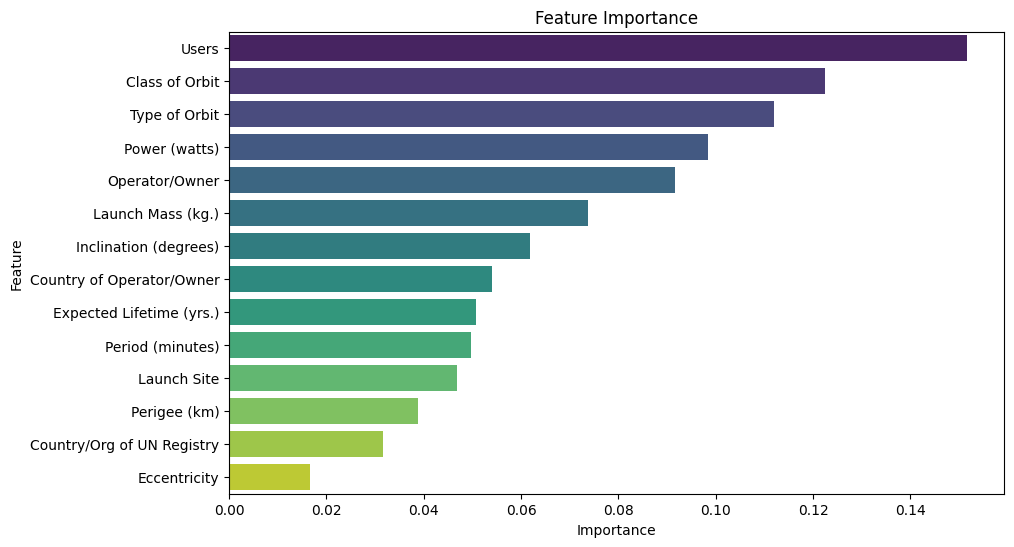

In [14]:
#RandomForest classifier
model1 = RandomForestClassifier(n_estimators=100, random_state=42)
model1.fit(X1, y1)

importances = model1.feature_importances_

encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = numerical_features + list(encoded_feature_names)

#mapping from encoded feature names back to their original names
feature_mapping = {feature: feature for feature in numerical_features}
for original_feature in categorical_features:
    for encoded_feature in encoded_feature_names:
        if encoded_feature.startswith(original_feature):
            feature_mapping[encoded_feature] = original_feature

mapped_feature_names = [feature_mapping[feature] for feature in feature_names]

#aggregate feature importances by original feature names
feature_importance_df = pd.DataFrame({'Feature': mapped_feature_names, 'Importance': importances})
feature_importance_agg = feature_importance_df.groupby('Feature').sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_agg.sort_values(by='Importance', ascending=False), palette='viridis')
plt.title('Feature Importance')
plt.show()

**'Users', 'Class of Orbit', 'Type of Orbit', and 'Power (watts)' appear to be the top features for predicting 'Purpose'**

**I have a lot of categorical data, so let's use LightGBM (Light Gradient-Boosting Machine).**

**What is LightGBM?**

A fast, distributed, high performance gradient boosting (GBT, GBDT, GBRT, GBM or MART) framework based on decision tree algorithms, 
used for ranking, classification and many other machine learning tasks.

https://lightgbm.readthedocs.io/en/latest/

In [15]:
selected_features2 = ['Users', 'Class of Orbit', 'Type of Orbit', 'Power (watts)']
target2 = 'Purpose'

sat_df2.dropna(subset=selected_features2 + [target2], inplace=True)

#convert numerical columns to numeric types
sat_df2['Power (watts)'] = pd.to_numeric(sat_df2['Power (watts)'], errors='coerce')
sat_df2.dropna(subset=['Power (watts)'], inplace=True)

#encode categorical features
label_encoders = {}
for col in ['Users', 'Class of Orbit', 'Type of Orbit']:
    le = LabelEncoder()
    sat_df2[col] = le.fit_transform(sat_df2[col])
    label_encoders[col] = le

#encode target variable
le_target = LabelEncoder()
sat_df2[target2] = le_target.fit_transform(sat_df2[target2])

In [16]:
#class distribution
class_counts = sat_df2[target2].value_counts()
print("Class distribution before removing rare classes:\n", class_counts)

#remove classes with too few samples
sat_df2 = sat_df2[sat_df2[target2].isin(class_counts[class_counts > 5].index)]

#class distribution again
class_counts = sat_df2[target2].value_counts()
print("Class distribution after removing rare classes:\n", class_counts)

Class distribution before removing rare classes:
 Purpose
0    150
2     39
6     11
8     10
3      3
4      3
7      2
1      1
5      1
Name: count, dtype: int64
Class distribution after removing rare classes:
 Purpose
0    150
2     39
6     11
8     10
Name: count, dtype: int64


In [17]:
#ignore warnings and loggings
warnings.filterwarnings("ignore")
logging.getLogger("lightgbm").setLevel(logging.ERROR)

X2 = sat_df2[selected_features2]
y2 = sat_df2[target2]

#feature engineering
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler())
])

X2 = pipeline.fit_transform(X2)

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)

#model
lgb_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(le_target.classes_),
    random_state=42,
    verbosity=-1,
    class_weight='balanced' #balance classes
)

#parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'n_estimators': [100, 200, 500],
    'boosting_type': ['gbdt', 'dart']
}

#GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters found: ", best_params)

Best parameters found:  {'boosting_type': 'dart', 'learning_rate': 0.1, 'n_estimators': 500, 'num_leaves': 31}


In [18]:
#predict on the test set
y_pred = best_model.predict(X_test)

#evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=0)

print("Classification Report:\n", report)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           2       0.89      1.00      0.94         8
           6       1.00      0.50      0.67         2
           8       1.00      1.00      1.00         2

    accuracy                           0.98        42
   macro avg       0.97      0.88      0.90        42
weighted avg       0.98      0.98      0.97        42

Accuracy: 97.62%


In [19]:
#save the model and pipeline
with open('purpose_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)
    
with open('pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [20]:
#load the model and pipeline
with open('purpose_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

with open('pipeline.pkl', 'rb') as f:
    loaded_pipeline = pickle.load(f)

In [21]:
#dummy data
dummy_data_list = [
    {'Users': 'Government', 'Class of Orbit': 'LEO', 'Type of Orbit': 'Polar', 'Power (watts)': 608},              #Should be: Earth Observation                         
    {'Users': 'Government', 'Class of Orbit': 'LEO', 'Type of Orbit': 'Sun-Synchronous', 'Power (watts)': 1100},   #Should be: Earth Observation                      
    {'Users': 'Military', 'Class of Orbit': 'LEO', 'Type of Orbit': 'Polar', 'Power (watts)': 300},                #Should be: Communications              
    {'Users': 'Government', 'Class of Orbit': 'LEO', 'Type of Orbit': 'Sun-Synchronous', 'Power (watts)': 1200}    #Should be: Earth Observation
]

dummy_data = pd.DataFrame(dummy_data_list)

#encode dummy data
for col in ['Users', 'Class of Orbit', 'Type of Orbit']:
    dummy_data[col] = label_encoders[col].transform(dummy_data[col])

#transform dummy data using the pipeline
dummy_data_transformed = loaded_pipeline.transform(dummy_data)

#predictions
dummy_pred = loaded_model.predict(dummy_data_transformed)
dummy_pred_labels = le_target.inverse_transform(dummy_pred)

for i, pred in enumerate(dummy_pred_labels):
    print(f"Predicted Purpose for dummy data set {i + 1}: {pred}")

Predicted Purpose for dummy data set 1: Earth Observation
Predicted Purpose for dummy data set 2: Earth Observation
Predicted Purpose for dummy data set 3: Communications
Predicted Purpose for dummy data set 4: Earth Observation
